# GitHub Ecosystem Mapping

In this notebook we will explore the Augur GitHub data to generate an ecosystem mapping of open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Respositories

In [3]:
aval_repos = pd.DataFrame()
repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT a.rg_name,
                a.repo_group_id,
                b.repo_name,
                b.repo_id,
                b.forked_from,
                b.repo_archived,
                b.repo_git
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id
            ORDER BY
                rg_name,
                repo_name;
    """)
aval_repos = pd.read_sql(repo_query, con=engine)
display(aval_repos)
aval_repos.dtypes

,rg_name,repo_group_id,repo_name,repo_id,forked_from,repo_archived,repo_git
0,3scale,25556,3scale,33134,Parent not available,0.0,https://github.com/3scale/3scale.github.io
1,3scale,25556,3scale-amp-openshift-templates,33126,Parent not available,0.0,https://github.com/3scale/3scale-amp-openshift...
2,3scale,25556,3scale-api-python,33130,3scale-qe/3scale-api-python,0.0,https://github.com/3scale/3scale-api-python
3,3scale,25556,3scale-api-ruby,33158,Parent not available,0.0,https://github.com/3scale/3scale-api-ruby
4,3scale,25556,3scale-go-client,33169,Parent not available,0.0,https://github.com/3scale/3scale-go-client
...,...,...,...,...,...,...,...
10956,zerodayz,25482,sosreport-operator,30872,andreaskaris/sosreport-operator,0.0,https://github.com/zerodayz/sosreport-operator
10957,zerodayz,25482,talos,30863,siderolabs/talos,0.0,https://github.com/zerodayz/talos
10958,zerodayz,25482,tests,30838,kata-containers/tests,0.0,https://github.com/zerodayz/tests
10959,zerodayz,25482,web,30839,openshifttips/web,0.0,https://github.com/zerodayz/web


rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
forked_from       object
repo_archived    float64
repo_git          object
dtype: object

## Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [4]:
issue_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            i.cntrb_id,
            i.issue_id
            FROM
            repo r, issues i
             WHERE
            i.repo_id = r.repo_id
            limit 50000
    """)
issue_contrib = pd.read_sql(repo_query, con=engine)
issue_contrib.columns =['Repo ID', 'Git', 'Issue Authors', 'Issue ID']

display(issue_contrib)
issue_contrib.dtypes

,Repo ID,Git,Issue Authors,Issue ID
0,24441,https://github.com/operate-first/operate-first...,25438.0,31034
1,24441,https://github.com/operate-first/operate-first...,25438.0,31033
2,24441,https://github.com/operate-first/operate-first...,25438.0,31036
3,24441,https://github.com/operate-first/operate-first...,25438.0,31035
4,24441,https://github.com/operate-first/operate-first...,25449.0,31029
...,...,...,...,...
49995,25795,https://github.com/eclipse/reddeer,NaN,262688
49996,25729,https://github.com/eclipse/omr,NaN,203837
49997,25729,https://github.com/eclipse/omr,NaN,203838
49998,25795,https://github.com/eclipse/reddeer,NaN,262689


Repo ID            int64
Git               object
Issue Authors    float64
Issue ID           int64
dtype: object

In [5]:
issue_contrib.nunique()

Repo ID            216
Git                216
Issue Authors      846
Issue ID         50000
dtype: int64

## Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [6]:
pr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prm.cntrb_id,
            prm.pull_request_id
            FROM
            repo r, pull_request_meta prm 
             WHERE
            prm.repo_id = r.repo_id
            limit 50000
    """)
pr_contrib = pd.read_sql(repo_query, con=engine)
pr_contrib.columns =['Repo ID', 'Git', 'PR Creators', 'PR ID']

display(pr_contrib)
pr_contrib.dtypes

,Repo ID,Git,PR Creators,PR ID
0,27458,https://github.com/operate-first/continuous-de...,25443,25430
1,27458,https://github.com/operate-first/continuous-de...,25465,25430
2,27458,https://github.com/operate-first/continuous-de...,25444,25431
3,27458,https://github.com/operate-first/continuous-de...,25465,25431
4,27458,https://github.com/operate-first/continuous-de...,25433,25432
...,...,...,...,...
49995,28335,https://github.com/ansible/ansible-modules-core,91339,67016
49996,28335,https://github.com/ansible/ansible-modules-core,58062,67016
49997,32524,https://github.com/openshift/test-pull-requests,2204263,72431
49998,32524,https://github.com/openshift/test-pull-requests,2204295,72431


Repo ID         int64
Git            object
PR Creators     int64
PR ID           int64
dtype: object

In [7]:
pr_contrib.nunique()

Repo ID          284
Git              284
PR Creators     2054
PR ID          24917
dtype: int64

## Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [8]:
prr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prr.cntrb_id,
            prr.pull_request_id
            FROM
            repo r, pull_request_reviews prr
             WHERE
            prr.repo_id = r.repo_id
            limit 50000
    """)
prr_contrib = pd.read_sql(repo_query, con=engine)
prr_contrib.columns =['Repo ID', 'Git', 'PR Reviewers', 'PRR ID']

display(prr_contrib)
prr_contrib.dtypes

,Repo ID,Git,PR Reviewers,PRR ID
0,27458,https://github.com/operate-first/continuous-de...,25443,25431
1,27458,https://github.com/operate-first/continuous-de...,25443,25432
2,27458,https://github.com/operate-first/continuous-de...,25444,25432
3,27458,https://github.com/operate-first/continuous-de...,25444,25430
4,27458,https://github.com/operate-first/continuous-de...,25446,25430
...,...,...,...,...
26800,28308,https://github.com/ansible/lightbulb,58328,65877
26801,28308,https://github.com/ansible/lightbulb,58179,65877
26802,28308,https://github.com/ansible/lightbulb,58059,65877
26803,28308,https://github.com/ansible/lightbulb,58232,65877


Repo ID          int64
Git             object
PR Reviewers     int64
PRR ID           int64
dtype: object

In [9]:
prr_contrib.nunique()

Repo ID          191
Git              191
PR Reviewers     961
PRR ID          9289
dtype: int64

## Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [10]:
commit_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            ca.cntrb_id,
            c.cmt_id
            FROM
            repo r, commits c, contributors_aliases ca
             WHERE
            c.repo_id = r.repo_id and
            c.cmt_committer_email = ca.alias_email
            limit 50000
    """)
commit_contrib = pd.read_sql(repo_query, con=engine)
commit_contrib.columns =['Repo ID', 'Git', 'Commit Creators', 'Commit ID']

display(commit_contrib)
commit_contrib.dtypes

,Repo ID,Git,Commit Creators,Commit ID
0,26835,https://github.com/linux-audit/audit-kernel,30149,16604325
1,26835,https://github.com/linux-audit/audit-kernel,30149,16624574
2,26835,https://github.com/linux-audit/audit-kernel,30149,16640974
3,26835,https://github.com/linux-audit/audit-kernel,30149,16645598
4,32165,https://github.com/openshift/ocp-release-opera...,57896,36771608
...,...,...,...,...
49995,32057,https://github.com/openshift/coredns,170450,36938537
49996,32057,https://github.com/openshift/coredns,170450,36938538
49997,32057,https://github.com/openshift/coredns,170450,36938539
49998,32057,https://github.com/openshift/coredns,170450,36938540


Repo ID             int64
Git                object
Commit Creators     int64
Commit ID           int64
dtype: object

In [11]:
commit_contrib.nunique()

Repo ID               68
Git                   68
Commit Creators       54
Commit ID          50000
dtype: int64

## Merge Data Sets

We will now merge all the data sets into a single data frame.

In [12]:
df_all_new = pd.merge(commit_contrib, issue_contrib, on=['Repo ID','Git'], how='outer')

In [13]:
df_all_new.nunique()

Repo ID              283
Git                  283
Commit Creators       54
Commit ID          50000
Issue Authors        846
Issue ID           50000
dtype: int64

In [14]:
df_all_new = pd.merge(df_all_new, pr_contrib, on=['Repo ID', 'Git'], how='outer')

In [15]:
df_all_new.nunique()

Repo ID              560
Git                  560
Commit Creators       54
Commit ID          50000
Issue Authors        846
Issue ID           50000
PR Creators         2054
PR ID              24917
dtype: int64

In [16]:
df_all_new = pd.merge(df_all_new, prr_contrib, on=['Repo ID', 'Git'], how='outer')

In [ ]:
df_all_new.nunique()

In [17]:
len(df_all_new)

65513811

In [18]:
# Drop all duplicate records
df_all_new.drop_duplicates(inplace=True)

In [19]:
len(df_all_new)

46463136

In [20]:
# Lets subset the first 50000 rows
df_all_subset = df_all_new[0:50000]

### Commit Contributor Graph

In [21]:
df_commit = df_all_subset.groupby(['Repo ID', 'Commit Creators']).size().unstack(fill_value=0)
df_commit.head()

Commit Creators,29197.0,29297.0,30149.0,30918.0,31418.0,42199.0,57770.0,57806.0,57896.0,57929.0,2210732.0,2210733.0,2212203.0,2219385.0,2228799.0,2230241.0
Repo ID,,,,,,,,,,,,,,,,
26835,155,15,92,3528,7,0,0,0,0,0,0,0,0,0,0,0
27572,177,17,43,3308,3,0,0,0,0,0,0,0,0,0,0,0
32165,0,0,0,0,0,13,47,18,69,23,5,7,1,1,1,2
36109,0,0,0,42468,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
df_commit.columns

Float64Index([  29197.0,   29297.0,   30149.0,   30918.0,   31418.0,   42199.0,
                57770.0,   57806.0,   57896.0,   57929.0, 2210732.0, 2210733.0,
              2212203.0, 2219385.0, 2228799.0, 2230241.0],
             dtype='float64', name='Commit Creators')

In [23]:
df_commit = df_commit.reset_index()

In [24]:
df_commit.head()

Commit Creators,Repo ID,29197.0,29297.0,30149.0,30918.0,31418.0,42199.0,57770.0,57806.0,57896.0,57929.0,2210732.0,2210733.0,2212203.0,2219385.0,2228799.0,2230241.0
0,26835,155,15,92,3528,7,0,0,0,0,0,0,0,0,0,0,0
1,27572,177,17,43,3308,3,0,0,0,0,0,0,0,0,0,0,0
2,32165,0,0,0,0,0,13,47,18,69,23,5,7,1,1,1,2
3,36109,0,0,0,42468,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
df_melted_commit = df_commit.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [26]:
df_melted_commit.head()

,Repo ID,Contributor,number
0,26835,29197.0,155
1,27572,29197.0,177
2,32165,29197.0,0
3,36109,29197.0,0
4,26835,29297.0,15


In [27]:
Repo_id = df_melted_commit['Repo ID'].to_list()
len(Repo_id)

64

In [28]:
contributor_id = df_melted_commit['Contributor'].to_list()
len(contributor_id)

64

In [29]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [30]:
nodes = G.nodes()
nodes

NodeView((26835, 29197.0, 27572, 32165, 36109, 29297.0, 30149.0, 30918.0, 31418.0, 42199.0, 57770.0, 57806.0, 57896.0, 57929.0, 2210732.0, 2210733.0, 2212203.0, 2219385.0, 2228799.0, 2230241.0))

In [31]:
nodes = list(nodes)
len(nodes)

20

In [32]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

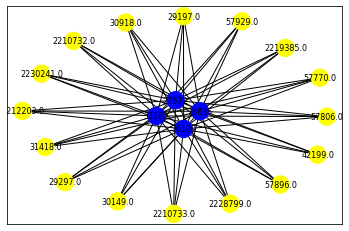

In [33]:
#fig = plt.figure(3, figsize=(500,500))
nx.draw_networkx(G, node_color=colors, font_size=8)

In [34]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 20
Number of edges: 64
Average degree:   6.4000


### Issue Contributor Graph

In [35]:
df_issue = df_all_subset.groupby(['Repo ID', 'Issue Authors']).size().unstack(fill_value=0)
df_issue.head()

Issue Authors
Repo ID


In [ ]:
df_issue.columns

In [ ]:
df_issue = df_issue.reset_index()

In [ ]:
df_issue.head()

In [ ]:
df_melted_issue = df_issue.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [ ]:
df_melted_issue.head()

In [ ]:
Repo_id = df_melted_issue['Repo ID'].to_list()
len(Repo_id)

In [ ]:
contributor_id = df_melted_issue['Contributor'].to_list()
len(contributor_id)

In [ ]:
G = nx.from_pandas_edgelist(df_melted_issue, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [ ]:
nodes = G.nodes()
nodes

In [ ]:
nodes = list(nodes)
len(nodes)

In [ ]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

In [ ]:
fig = plt.figure(3, figsize=(500,500))
nx.draw_networkx(G, node_color=colors, font_size=8)

In [ ]:
print(nx.info(G))

### PR Contributor Graph

In [36]:
df_pr = df_all_subset.groupby(['Repo ID', 'PR Creators']).size().unstack(fill_value=0)
df_pr.head()

PR Creators,25650.0,27010.0,30165.0,40325.0,40326.0,40327.0,40328.0,40329.0,40330.0,40331.0
Repo ID,,,,,,,,,,
36109,21120,1920,2148,3840,1920,1920,2400,2400,2400,2400


In [37]:
df_pr = df_pr.reset_index()

In [38]:
df_melted_pr = df_pr.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [39]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [40]:
nodes = G.nodes()

In [41]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

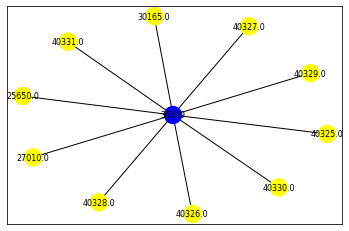

In [42]:
nx.draw_networkx(G, node_color=colors, font_size=8)

### PR Reviewers Graph

In [43]:
df_prr = df_all_subset.groupby(['Repo ID', 'PR Reviewers']).size().unstack(fill_value=0)
df_prr.head()

PR Reviewers,27041.0,27211.0,27344.0,27821.0,29714.0,30475.0,31107.0,31197.0,36688.0,37958.0,...,43325.0,43326.0,43327.0,43328.0,43329.0,43330.0,43331.0,43332.0,43333.0,43335.0
Repo ID,,,,,,,,,,,,,,,,,,,,,
36109,89,89,88,89,89,89,89,89,89,89,...,88,88,88,88,88,88,88,88,88,88


In [44]:
df_prr = df_prr.reset_index()

In [45]:
df_melted_prr = df_prr.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [46]:
G = nx.from_pandas_edgelist(df_melted_prr, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [47]:
nodes = G.nodes()

In [48]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

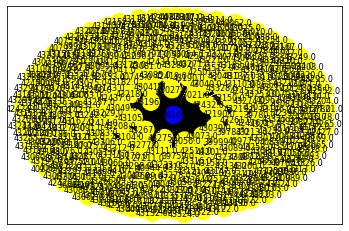

In [49]:
nx.draw_networkx(G, node_color=colors, font_size=8)